# Data Challenge - New York City Property Investment

Problem Statement
You are consulting for a real estate company that has a niche in purchasing properties to rent out short-term as part of their business model specifically within New York City.  The real estate company has already concluded that two bedroom properties are the most profitable; however, they do not know which zip codes are the best to invest in.    

The real estate company has engaged your firm to build out a data product and provide your conclusions to help them understand which zip codes would generate the most profit on short term rentals within New York City.
.  You will be looking at publicly available data from Zillow and AirBnB:

●	Cost data: Zillow provides us an estimate of value for two-bedroom properties

●	Revenue data: AirBnB is the medium through which the investor plans to lease out their investment property. Fortunately for you, we are able to see how much properties in certain neighborhoods rent out for in New York City

●	You can assume an occupancy rate of 75% or you can come up with your own model to calculate occupancy; just let us know how you came to that calculation

After meeting with the strategy team, you’ve got an idea of where to start, key concerns, and how you can help this real estate company with the market data while keeping the following assumptions in mind:

●	The investor will pay for the property in cash (i.e. no mortgage/interest rate will need to be accounted for).

●	The time value of money discount rate is 0% (i.e. $1 today is worth the same 100 years from now).

●	All properties and all square feet within each locale can be assumed to be homogeneous (i.e. a 1000 square foot property in a locale such as Bronx or Manhattan generates twice the revenue and costs twice as much as any other 500 square foot property within that same locale.)

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as pp
from matplotlib import rcParams
from datetime import datetime, timedelta, date

#for the Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder


#From the prediction model tutorial
import warnings
warnings.filterwarnings("ignore")

In [3]:
#To make sure that all mathplotlib output is displayed in the Notebook instead of an external window
%matplotlib inline

### Importing and Cleaning the Zillow data

In [4]:
zillow = pd.read_csv("Zip_Zhvi_2bedroom.csv")
zillow_NYC = zillow[(zillow['City']=='New York') & (zillow['State']=='NY')]
zillow_NYC.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
2,61637,10023,New York,NY,New York,New York,3,NaN,NaN,NaN,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
13,61703,10128,New York,NY,New York,New York,14,NaN,NaN,NaN,...,1526000,1523700,1527200,1541600.0,1557800,1582900,1598900,1646100,1720500,1787100
14,61625,10011,New York,NY,New York,New York,15,NaN,NaN,NaN,...,2354000,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400
20,61617,10003,New York,NY,New York,New York,21,NaN,NaN,NaN,...,1932800,1930400,1937500,1935100.0,1915700,1916500,1965700,2045300,2109100,2147000


In [5]:
#Renaming RegionName to ZipCode
zillow_NYC.rename(columns={'RegionName':'ZipCode'}, inplace=True)

In [6]:
#checking for dups in the zipcode list. None found
zillow_NYC['ZipCode'].nunique()

25

### Importing USPS Zipcode by Borough

data found at https://tools.usps.com/zip-code-lookup.htm?bycitystate and search by the 5 Boroughs

In [7]:
NYC_zip = pd.read_csv("NYC_ZipCodes_USPS.csv")
NYC_zip.head()

,ZipCode,Borough
0,10001,Manhattan
1,10002,Manhattan
2,10003,Manhattan
3,10004,Manhattan
4,10005,Manhattan


We will use the data to validate if the zipcodes from the Zillow file are actually New York City zipcodes results will show 1 - yes and 0 - no

For scalability purposes we would use the census data and extract all zipcodes by city/ county/ Borough.

In [8]:
pd.Series(zillow_NYC.ZipCode.isin(NYC_zip.ZipCode).values.astype(int), zillow_NYC.ZipCode.values)

10025    1
10023    1
10128    1
10011    1
10003    1
11201    1
11234    1
10314    1
11215    1
10028    1
10021    1
10014    1
10036    1
11434    1
10306    1
10312    1
10022    1
11217    1
10013    1
11231    1
10304    1
10305    1
10309    1
10308    1
10303    1
dtype: int32

### Filtering and transforming zillow data for use predict analytics

In [9]:
#dropping columns we do not need
zillow_NYC_cleaned = zillow_NYC.drop(['RegionID', 'Metro', 'SizeRank'], axis = 1) 

#Left Join with NYC_zip to get the Boroughs
#NYC_zip.rename(columns={'zip':'ZipCode'}, inplace=True)
NYC_zip['ZipCode'] = NYC_zip['ZipCode'].astype(str)
zillow_NYC_cleaned['ZipCode'] = zillow_NYC_cleaned['ZipCode'].astype(str)
zillow_NYC_cleaned = zillow_NYC_cleaned.merge(NYC_zip, on = 'ZipCode', how='left')
zillow_NYC_cleaned.head()


,ZipCode,City,State,CountyName,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,Borough
0,10025,New York,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,...,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000,Manhattan
1,10023,New York,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,...,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300,Manhattan
2,10128,New York,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,...,1523700,1527200,1541600.0,1557800,1582900,1598900,1646100,1720500,1787100,Manhattan
3,10011,New York,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,...,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400,Manhattan
4,10003,New York,NY,New York,NaN,NaN,NaN,NaN,NaN,NaN,...,1930400,1937500,1935100.0,1915700,1916500,1965700,2045300,2109100,2147000,Manhattan


In [10]:
#using pd.melt() to unpivot the dates
zillow_NYC_upvt = pd.melt(zillow_NYC_cleaned, id_vars =['ZipCode','City','State','CountyName', 'Borough'], 
                           var_name ='Date', value_name ='Price') 

In [11]:
zillow_NYC_upvt.head(25)

,ZipCode,City,State,CountyName,Borough,Date,Price
0,10025,New York,NY,New York,Manhattan,1996-04,NaN
1,10023,New York,NY,New York,Manhattan,1996-04,NaN
2,10128,New York,NY,New York,Manhattan,1996-04,NaN
3,10011,New York,NY,New York,Manhattan,1996-04,NaN
4,10003,New York,NY,New York,Manhattan,1996-04,NaN
5,11201,New York,NY,Kings,Brooklyn,1996-04,NaN
6,11234,New York,NY,Kings,Brooklyn,1996-04,NaN
7,10314,New York,NY,Richmond,Staten Island,1996-04,123100.0
8,11215,New York,NY,Kings,Brooklyn,1996-04,NaN
9,10028,New York,NY,New York,Manhattan,1996-04,NaN


### Forecasting to simulate the property prices in 07/2019 (same month/year of the Airbnb rental prices)

In [12]:
#creating time series with zip, year-month, and price
zillow_timeseries = zillow_NYC_upvt[['ZipCode','City','State','CountyName','Date','Price', 'Borough']].copy()

#transforming year-month in datetime obj
zillow_timeseries['Date'] = pd.to_datetime(zillow_timeseries['Date'])
zillow_timeseries['Price'] = zillow_timeseries['Price'].astype(float)
zillow_timeseries['ZipCode'] = zillow_timeseries['ZipCode'].astype(str)

zillow_timeseries.head()

,ZipCode,City,State,CountyName,Date,Price,Borough
0,10025,New York,NY,New York,1996-04-01,NaN,Manhattan
1,10023,New York,NY,New York,1996-04-01,NaN,Manhattan
2,10128,New York,NY,New York,1996-04-01,NaN,Manhattan
3,10011,New York,NY,New York,1996-04-01,NaN,Manhattan
4,10003,New York,NY,New York,1996-04-01,NaN,Manhattan


In [13]:
#plot size
rcParams['figure.figsize'] = 15,5

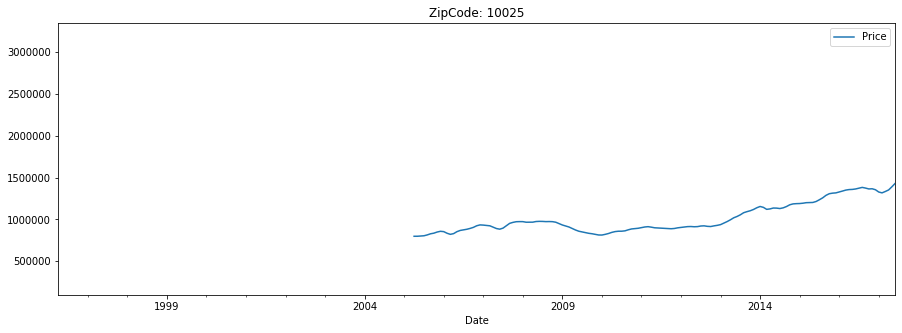

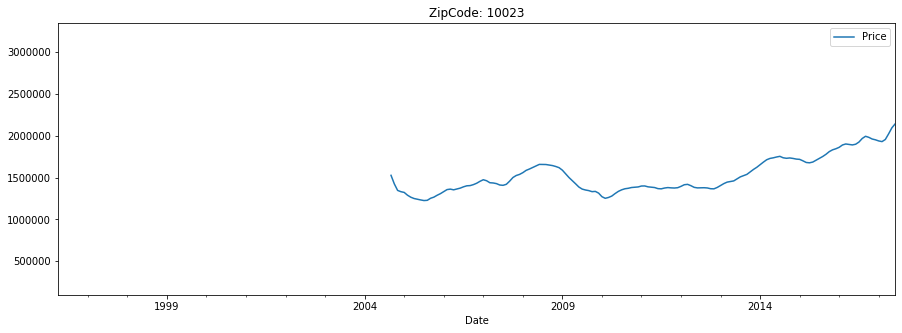

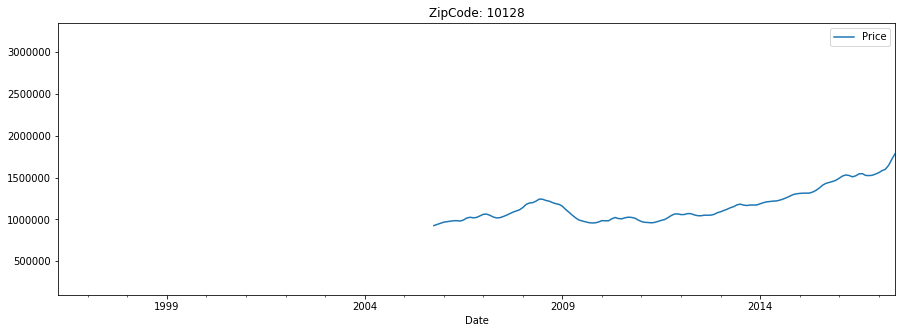

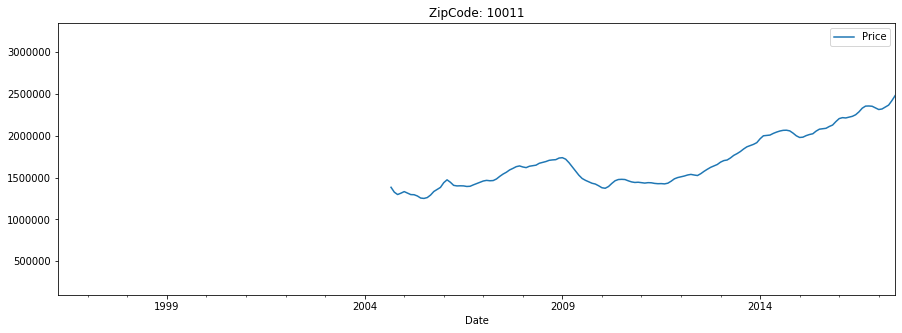

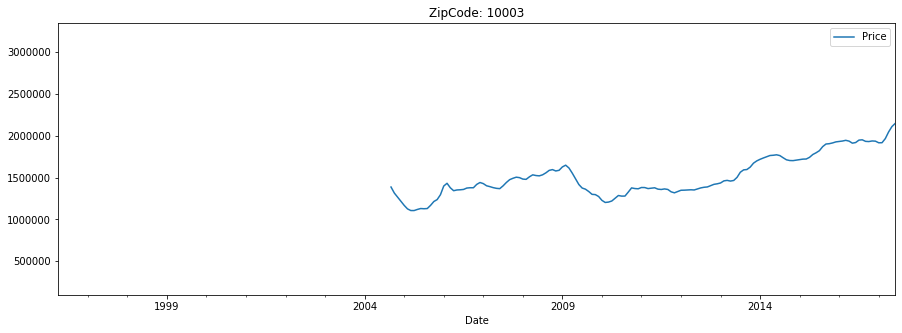

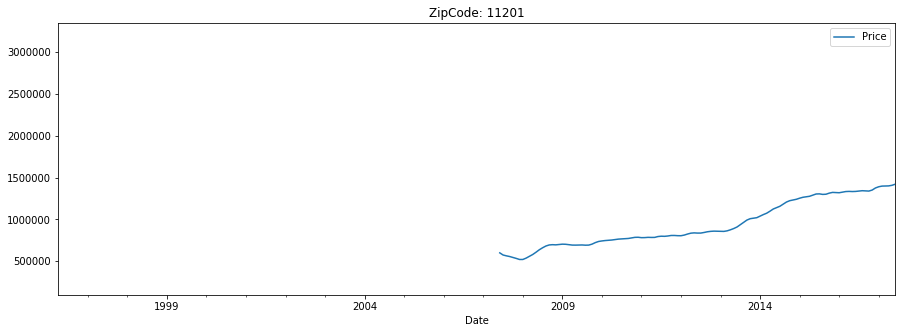

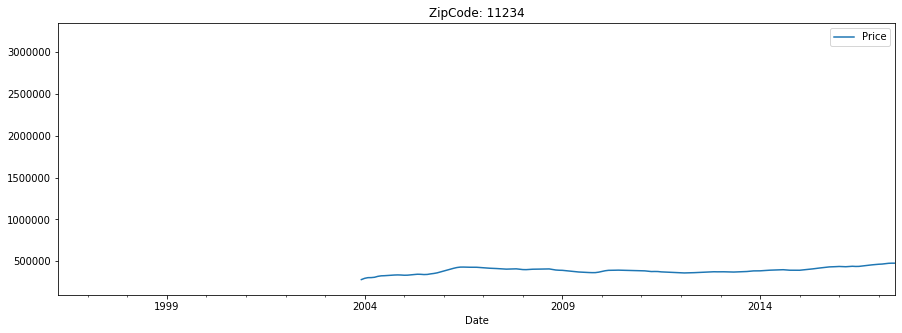

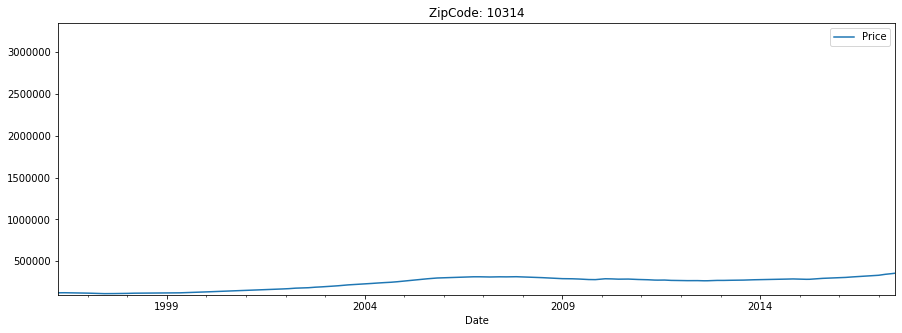

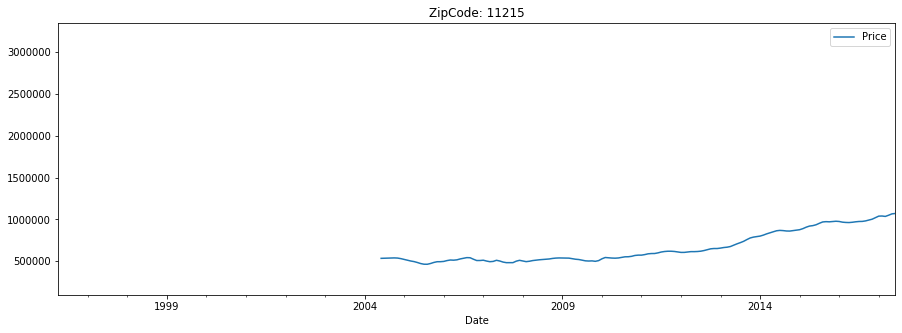

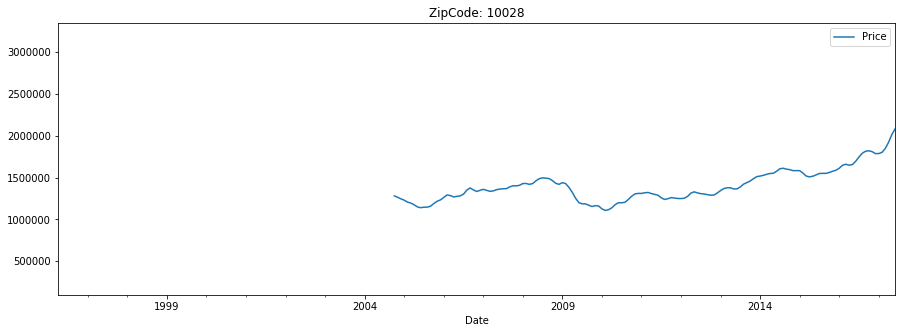

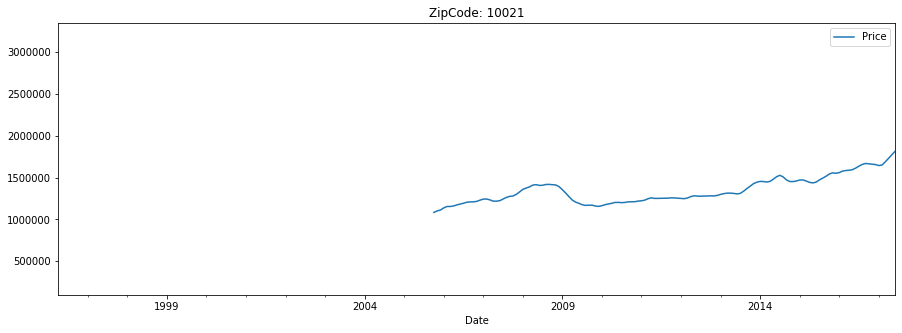

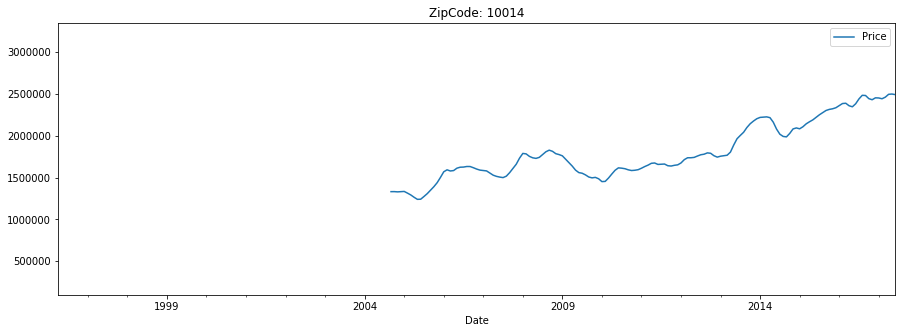

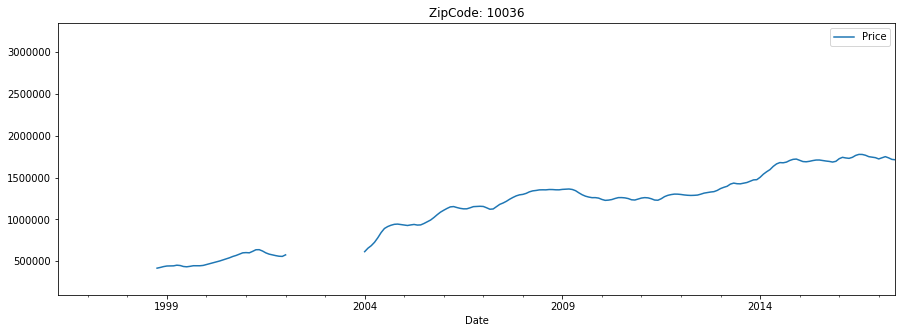

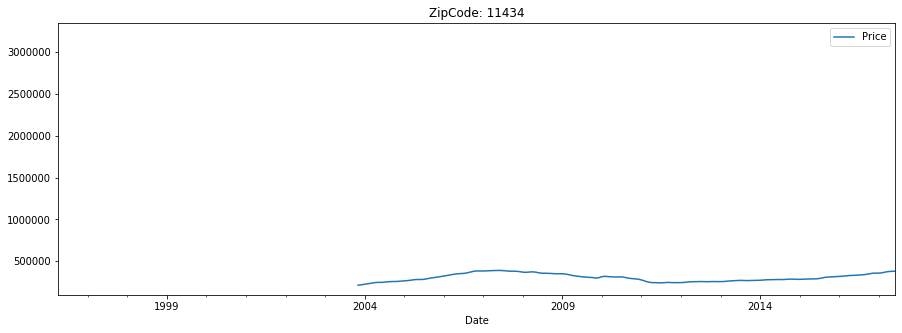

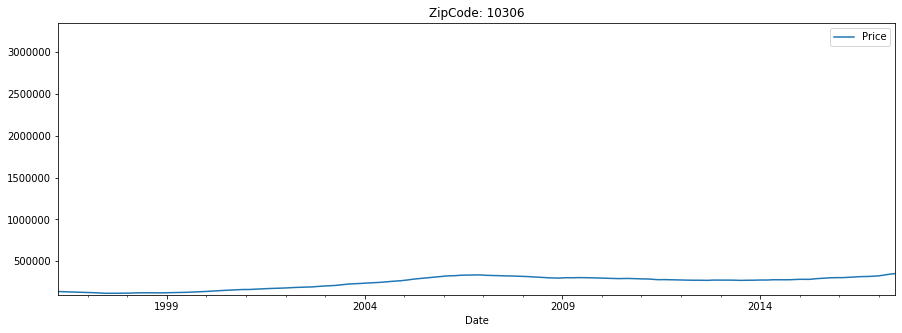

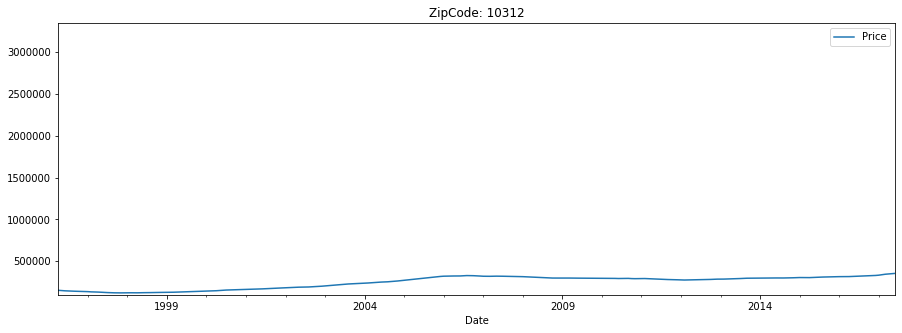

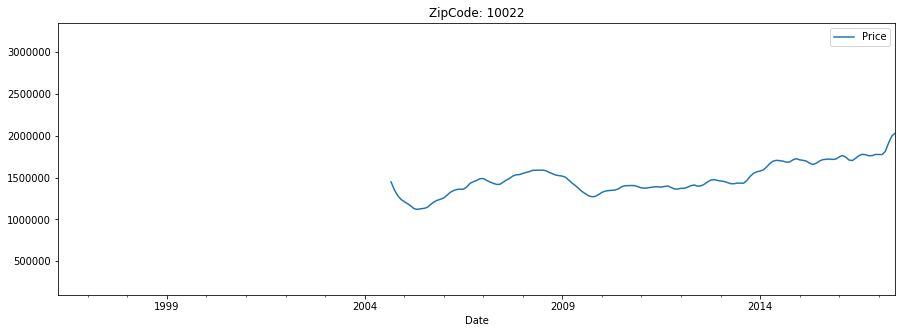

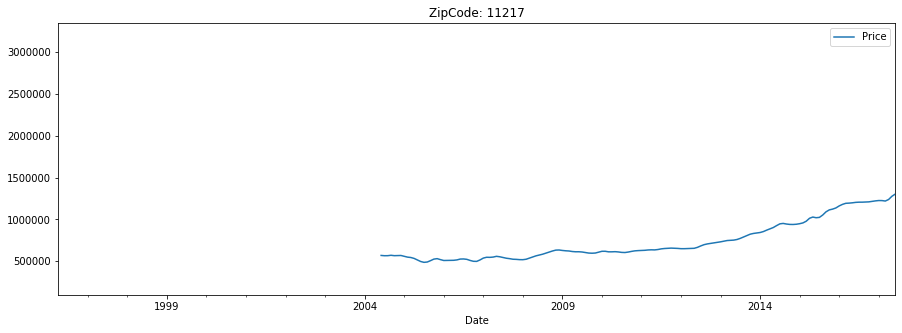

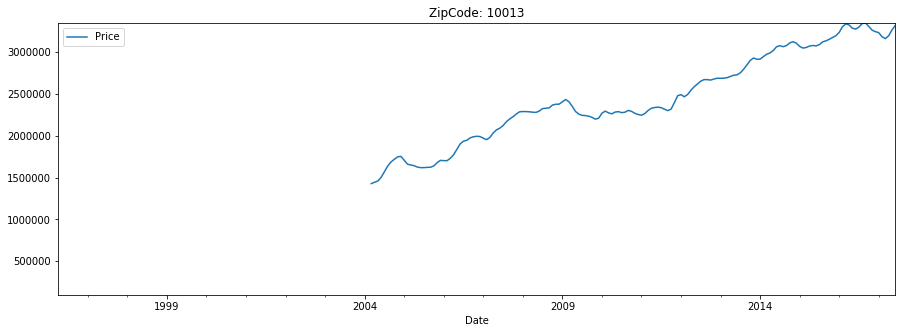

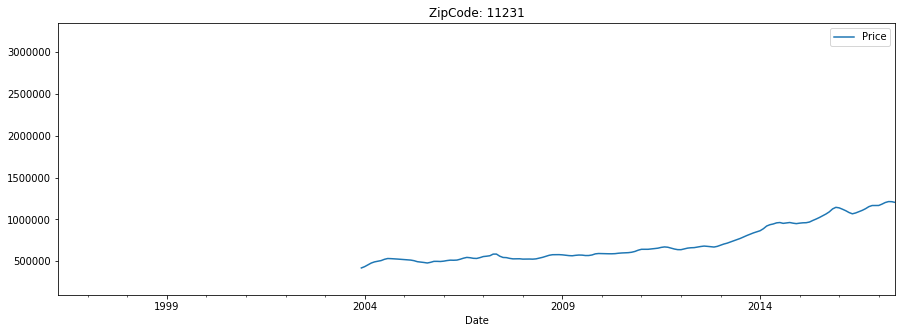

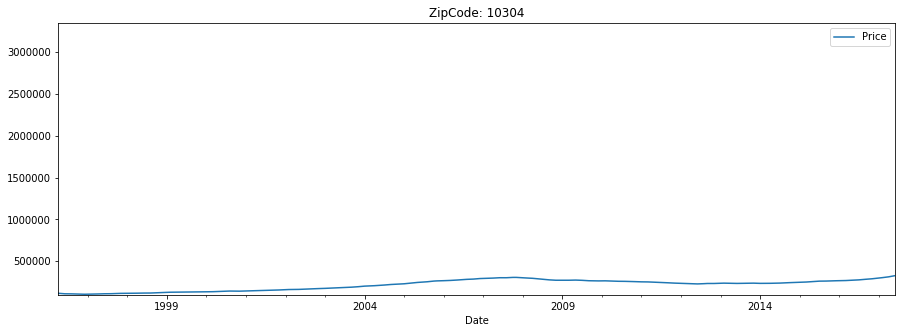

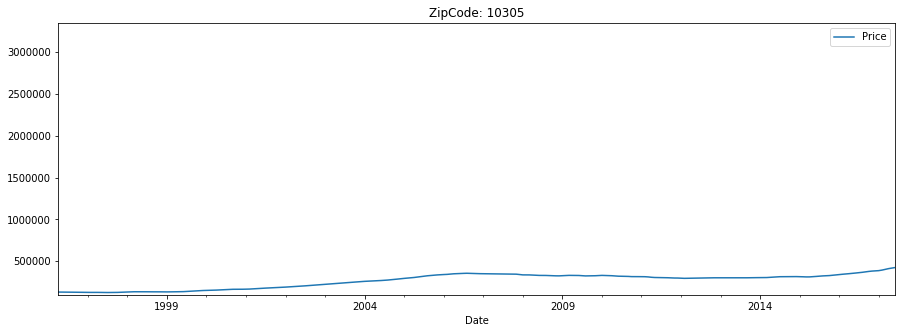

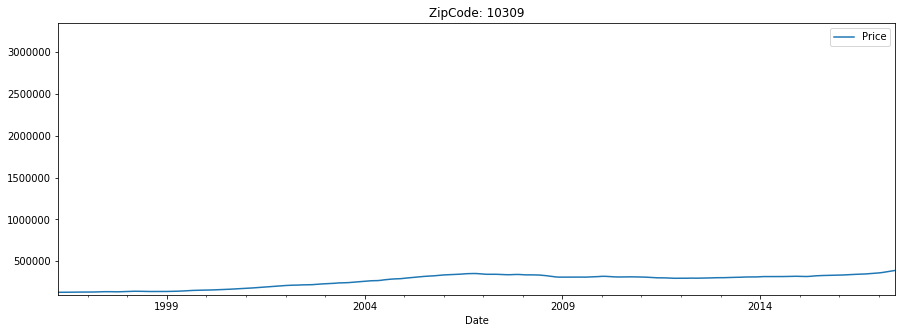

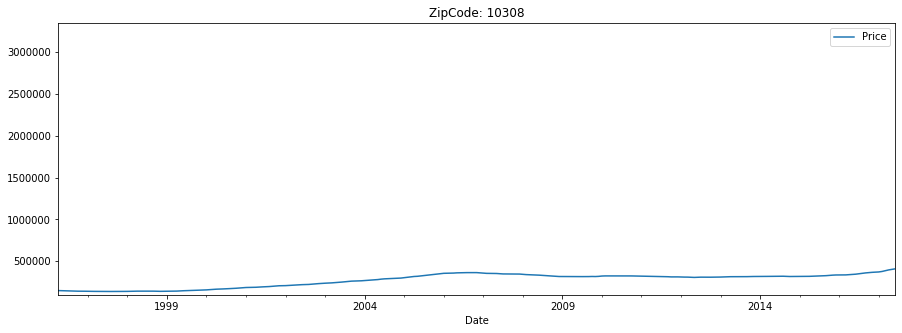

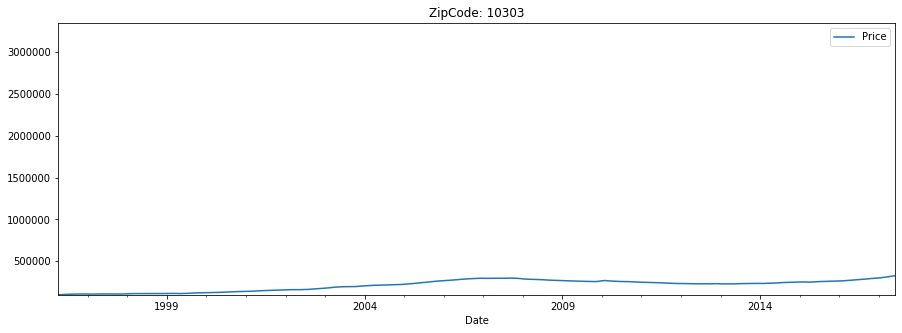

In [14]:
#plotting the prices over time grouped by zipcodes
minlimit = np.nanmin(zillow_timeseries['Price'])
maxlimit = np.nanmax(zillow_timeseries['Price'])

#unique zips
zips = list(zillow_timeseries['ZipCode'].unique())
for z in zips:
    data = zillow_timeseries[zillow_timeseries['ZipCode']==z]
    axis = data.plot(x='Date', y='Price', title = "ZipCode: " + z)
    axis.set_ylim(minlimit, maxlimit)
   

### Identifying zip code 10036 start and end of Null data interval 

In [15]:
#To find the NaN gap for the 10036 zip between 2002 and 2004 based in the graph plotted above
zillow_timeseries[(zillow_timeseries['ZipCode']=='10036') & (zillow_timeseries['Date']>='2001-11-01') & 
                  (zillow_timeseries['Date']<='2004-01-01')]

,ZipCode,City,State,CountyName,Date,Price,Borough
1687,10036,New York,NY,New York,2001-11-01,560200.0,Manhattan
1712,10036,New York,NY,New York,2001-12-01,558000.0,Manhattan
1737,10036,New York,NY,New York,2002-01-01,576500.0,Manhattan
1762,10036,New York,NY,New York,2002-02-01,NaN,Manhattan
1787,10036,New York,NY,New York,2002-03-01,NaN,Manhattan
1812,10036,New York,NY,New York,2002-04-01,NaN,Manhattan
1837,10036,New York,NY,New York,2002-05-01,NaN,Manhattan
1862,10036,New York,NY,New York,2002-06-01,NaN,Manhattan
1887,10036,New York,NY,New York,2002-07-01,NaN,Manhattan
1912,10036,New York,NY,New York,2002-08-01,NaN,Manhattan


The gap is from 2002-01-01 to 2004-01-01, for now I will drop all nulls but for future improvements possibily it would be a better way to try to predict what was the price in the missing interval.


In [16]:
#Dropping the NaNs
ztimeseries_clean = zillow_timeseries.dropna(axis = 0, subset=['Price'], how='all')

### Now we are going to test the Linear Regression as well observe its efficiency

We will use the zip code 10025

In [17]:
date_price = ztimeseries_clean[ztimeseries_clean['ZipCode']=='10025'].copy()
date_price.head()

,ZipCode,City,State,CountyName,Date,Price,Borough
2700,10025,New York,NY,New York,2005-04-01,798600.0,Manhattan
2725,10025,New York,NY,New York,2005-05-01,798800.0,Manhattan
2750,10025,New York,NY,New York,2005-06-01,801500.0,Manhattan
2775,10025,New York,NY,New York,2005-07-01,804600.0,Manhattan
2800,10025,New York,NY,New York,2005-08-01,814900.0,Manhattan


In [18]:
# Using encoder to make Borough as number to use in the Linear Regression model
# using pd.to_numeric to convert Date and ZipCode into unix time because the model needs the values to be numbers

enc = LabelEncoder()
date_price['Borough'] = enc.fit_transform(date_price['Borough'])
date_price['ZipCode'] = enc.fit_transform(date_price['ZipCode'])
date_price['Date'] = pd.to_numeric(date_price['Date'])
#date_price.reset_index(inplace=True)
date_price.head()

,ZipCode,City,State,CountyName,Date,Price,Borough
2700,0,New York,NY,New York,1112313600000000000,798600.0,0
2725,0,New York,NY,New York,1114905600000000000,798800.0,0
2750,0,New York,NY,New York,1117584000000000000,801500.0,0
2775,0,New York,NY,New York,1120176000000000000,804600.0,0
2800,0,New York,NY,New York,1122854400000000000,814900.0,0


In [58]:
# defining the independent variables

x = date_price['Date']#.loc[:, ['ZipCode','Date', 'Borough']]

# defining the dependent variable
y = date_price['Price']

In [59]:
#spliting the data in training set and test set
"""
Split the data set into 2 partitions:
A training set: contains the majority of the rows (80%)
A test set: contains the remaining minority of the rows (20%)
"""
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)

In [60]:
x_train.head()

3225    1167609600000000000
6075    1467331200000000000
3800    1228089600000000000
4450    1296518400000000000
3025    1146441600000000000
Name: Date, dtype: int64

In [61]:
#fitting the linear regression model
 # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
    #https://medium.com/@swethalakshmanan14/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
    #(b)y intercept = True and normalize = True because the features (zip, date, borough) have different ranges.
    #using .values.reshape(-1,1) because .fit() requires 2D array

linear = LinearRegression(fit_intercept=True, normalize=True)
linear.fit(x_train.values.reshape(-1,1), y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [62]:
# generating a prediction
# We have to use reshape(-1, 1) on the x_train because the .predict() function needs a 2D array. .values.reshape(-1, 1)

pred = linear.predict(x_test.values.reshape(-1,1))

In [31]:
#checking the prediction efficiency

r2_score(y_test, pred)

0.7300228251074387

In [32]:
#printing contrast from Actual to Predict results 
df = pd.DataFrame({'Actual': y_test, 'Predicted': np.round(pred,2), 'Diff':abs(y_test-np.round(pred,2))
                   , '%Diff':round((abs(y_test-np.round(pred,2))/y_test)*100,2)})
df.head()

,Actual,Predicted,Diff,%Diff
3150,905000.0,815801.18,89198.82,9.86
6250,1317300.0,1259522.97,57777.03,4.39
2775,804600.0,762098.62,42501.38,5.28
3050,868300.0,801464.82,66835.18,7.70
4175,831700.0,962337.48,130637.48,15.71


### From this point and on we will use the Linear Regression to forecast all property prices by zip code

In [193]:
#create a df that will hold the zips and the property prediction prices in 2019-07, same year-month of Airbnb data

PriceZipPrediction = ztimeseries_clean.loc[:,['ZipCode','City','State','CountyName','Borough']].drop_duplicates()
PriceZipPrediction['Date'] = pd.to_datetime('2019-07-01')
PriceZipPrediction['PricePrediction'] = 0
PriceZipPrediction

,ZipCode,City,State,CountyName,Borough,Date,PricePrediction
7,10314,New York,NY,Richmond,Staten Island,2019-07-01,0
14,10306,New York,NY,Richmond,Staten Island,2019-07-01,0
15,10312,New York,NY,Richmond,Staten Island,2019-07-01,0
20,10304,New York,NY,Richmond,Staten Island,2019-07-01,0
21,10305,New York,NY,Richmond,Staten Island,2019-07-01,0
22,10309,New York,NY,Richmond,Staten Island,2019-07-01,0
23,10308,New York,NY,Richmond,Staten Island,2019-07-01,0
24,10303,New York,NY,Richmond,Staten Island,2019-07-01,0
762,10036,New York,NY,New York,Manhattan,2019-07-01,0
2288,11434,New York,NY,Queens,Queens,2019-07-01,0


Updating PriceZipPrediction with the prices forecast

In [194]:
"""zips = list(zillow_timeseries['ZipCode'].unique())
for z in zips:
    data = zillow_timeseries[zillow_timeseries['ZipCode']==z]
    axis = data.plot(x='Date', y='Price', title = "ZipCode: " + z)
    axis.set_ylim(minlimit, maxlimit)
"""
#running a linear regression for each zip
zippred = list(PriceZipPrediction['ZipCode'].unique())
#date_price = ztimeseries_clean.copy()
for z in zippred:
    date_price = ztimeseries_clean[zillow_timeseries['ZipCode']==z].copy()
    #data = date_price[date_price['ZipCode']==z]
    # using pd.to_numeric to convert Date into numerical value because the model accepts numbers
    date_price['Date'] = pd.to_numeric(date_price['Date'])
    
    # defining the independent variables
    x = date_price['Date']

    # defining the dependent variable
    y = date_price['Price']
    
    #spliting the data in training set and test set
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)
    
    #fitting the linear regression model
    linear = LinearRegression(fit_intercept=True, normalize=True)
    linear.fit(x_train.values.reshape(-1,1), y_train)
    
    #Using the PriceZipPrediction as x_test for to calculate the prediction
    pp = PriceZipPrediction[PriceZipPrediction['ZipCode']==z]
    pp['Date'] = pd.to_numeric(pp['Date'])
    # defining the dependent variable
    pp_x = pp['Date']
    #assigning the prediction
    pp['PricePrediction'] = np.round(linear.predict(pp_x.values.reshape(-1,1)),2)
    #transform the Date in datetime
    pp['Date'] = pd.to_datetime(pp['Date'])
    #updating PriceZipPrediction
    PriceZipPrediction[PriceZipPrediction['ZipCode']==z] = pp
    
    #print(linear.predict(pp_x.values.reshape(-1,1)))
    #assigning prediction to correct column
    #pp['PricePrediction'] = linear.predict(pp_x.values.reshape(-1,1))
    #
    # creating position and label variables 


In [195]:
PriceZipPrediction

,ZipCode,City,State,CountyName,Borough,Date,PricePrediction
7,10314,New York,NY,Richmond,Staten Island,2019-07-01,370222.64
14,10306,New York,NY,Richmond,Staten Island,2019-07-01,373215.33
15,10312,New York,NY,Richmond,Staten Island,2019-07-01,380404.16
20,10304,New York,NY,Richmond,Staten Island,2019-07-01,323444.65
21,10305,New York,NY,Richmond,Staten Island,2019-07-01,414771.21
22,10309,New York,NY,Richmond,Staten Island,2019-07-01,408498.10
23,10308,New York,NY,Richmond,Staten Island,2019-07-01,411297.32
24,10303,New York,NY,Richmond,Staten Island,2019-07-01,324659.55
762,10036,New York,NY,New York,Manhattan,2019-07-01,1960173.09
2288,11434,New York,NY,Queens,Queens,2019-07-01,306552.70


### Importing and Cleaning the Airbnb data

In [115]:
#briging airbnb data
listings = pd.read_csv("listings.csv")

In [116]:
#filtering by 2beds 
listings_twobedrooms = listings[listings['bedrooms']==2]
#filtering by the same zips from PriceZipPrediction
listings_2bed_zip = listings_twobedrooms[listings_twobedrooms['zipcode'].isin(zippred)]

When filtering the Airbnb to only 2 bedrooms apartments we observe the zipcodes 10312 and 10309 are not present; therefore we will not be consider for our recommendation 

In [117]:
listings_twobedrooms[listings_twobedrooms['zipcode']=='10312']

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


In [118]:
listings_twobedrooms[listings_twobedrooms['zipcode']=='10309']

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month


In [177]:
#selecting a subset of fields
listings_2bed_zip_clean = listings_2bed_zip.loc[:,['id','name', 'city', 'neighbourhood','state','zipcode','latitude', 
                                                   'longitude', 'is_location_exact','square_feet', 'price', 
                                                   'weekly_price', 'monthly_price', 'cleaning_fee']].copy().reset_index()

In [178]:
listings_2bed_zip_clean.drop(['index'], axis=1, inplace=True)
#Removing the $ sign
listings_2bed_zip_clean['price'] = listings_2bed_zip_clean['price'].map(lambda x: x.lstrip('$'))
listings_2bed_zip_clean['cleaning_fee'] = listings_2bed_zip_clean['cleaning_fee'].astype(str)
listings_2bed_zip_clean['cleaning_fee'] = listings_2bed_zip_clean['cleaning_fee'].map(lambda x: x.lstrip('$'))
#Removing the ',' thousand sign (like in 2,000.00)
listings_2bed_zip_clean['price'] = listings_2bed_zip_clean['price'].str.replace(',','')
listings_2bed_zip_clean['price'] = listings_2bed_zip_clean['price'].astype(float)
listings_2bed_zip_clean['cleaning_fee'] = listings_2bed_zip_clean['cleaning_fee'].str.replace(',','')
listings_2bed_zip_clean['cleaning_fee'] = listings_2bed_zip_clean['cleaning_fee'].astype(float)
listings_2bed_zip_clean['cleaning_fee'] = listings_2bed_zip_clean['cleaning_fee'].fillna(0)

listings_2bed_zip_clean.head()

,id,name,city,neighbourhood,state,zipcode,latitude,longitude,is_location_exact,square_feet,price,weekly_price,monthly_price,cleaning_fee
0,16458,Light-filled 2B duplex in the heart of Park Sl...,Brooklyn,Brooklyn,NY,11215,40.67343,-73.98338,t,NaN,225.0,NaN,NaN,0.0
1,20853,2-bed brownstone duplex + garden,Brooklyn,Brooklyn,NY,11217,40.68035,-73.97162,t,NaN,250.0,"$1,400.00","$4,000.00",250.0
2,23135,House On Henry (3rd FLR Suite),Brooklyn,Carroll Gardens,NY,11231,40.67967,-74.00154,t,NaN,175.0,NaN,NaN,65.0
3,27006,Comfortable UWS 2-BD Family-Friendly Brownstone,New York,Manhattan,NY,10023,40.77823,-73.97637,t,NaN,235.0,"$2,000.00","$6,000.00",120.0
4,27659,3 Story Town House in Park Slope,Brooklyn,Brooklyn,NY,11215,40.66499,-73.97925,t,NaN,400.0,"$2,700.00",NaN,120.0


Adding the price and cleaning fee into a single column TotalPrice

In [179]:
listings_2bed_zip_clean['TotalPrice'] = listings_2bed_zip_clean['price'] + listings_2bed_zip_clean['cleaning_fee']

In [180]:
listings_2bed_zip_clean.head()

,id,name,city,neighbourhood,state,zipcode,latitude,longitude,is_location_exact,square_feet,price,weekly_price,monthly_price,cleaning_fee,TotalPrice
0,16458,Light-filled 2B duplex in the heart of Park Sl...,Brooklyn,Brooklyn,NY,11215,40.67343,-73.98338,t,NaN,225.0,NaN,NaN,0.0,225.0
1,20853,2-bed brownstone duplex + garden,Brooklyn,Brooklyn,NY,11217,40.68035,-73.97162,t,NaN,250.0,"$1,400.00","$4,000.00",250.0,500.0
2,23135,House On Henry (3rd FLR Suite),Brooklyn,Carroll Gardens,NY,11231,40.67967,-74.00154,t,NaN,175.0,NaN,NaN,65.0,240.0
3,27006,Comfortable UWS 2-BD Family-Friendly Brownstone,New York,Manhattan,NY,10023,40.77823,-73.97637,t,NaN,235.0,"$2,000.00","$6,000.00",120.0,355.0
4,27659,3 Story Town House in Park Slope,Brooklyn,Brooklyn,NY,11215,40.66499,-73.97925,t,NaN,400.0,"$2,700.00",NaN,120.0,520.0


Now we will look for outliers in our data

In [121]:
import seaborn as sns

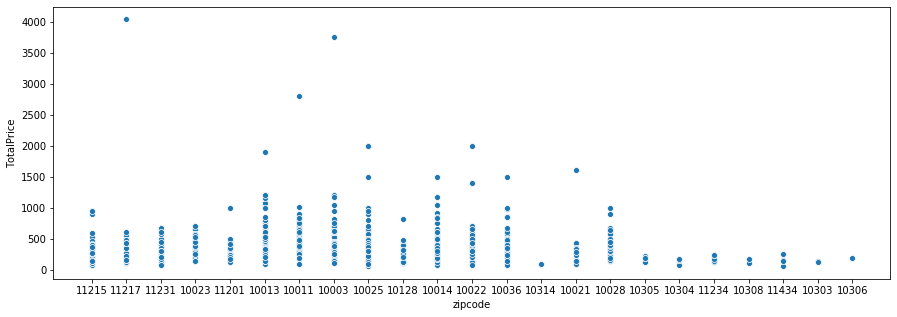

In [181]:
sns.scatterplot(x=listings_2bed_zip_clean['zipcode'], y=listings_2bed_zip_clean['TotalPrice'])
#sns.boxplot(x=listings_2bed_zip_clean["price"])
#sns.boxplot(x="zipcode", y="price", data=listings_2bed_zip_clean, palette="PRGn")
#sns.despine(offset=10, trim=True)

We see some outliers specially at zipcode 11217 and 10003.
We also observe that most of the outliers are above the 1500 dollars rent price, so at this time, considering the size of the the data and the vizualization above, we will simply filter the dataframe based on prices below or equal $1500.

For larger volumes of data or for those that are not that simple to spot trends such as the discribed above we could use the Interquartile Range (IQR) to generate a Lower and Upper fences to filter our data grouping it by the zipcode as below:

Calculating Q1 (first quartile) and Q3 (third quartile) grouping by the zipcode
Q1 = listings_2bed_zip_clean.groupby('zipcode')['price'].quantile(0.25)
Q3 = listings_2bed_zip_clean.groupby('zipcode')['price'].quantile(0.75)

Calculating the interquartile range (measure of variability, based on dividing a data set into quartiles.)
IQR = Q3 - Q1

Lower_Fence = Q1 - (1.5 * IQR) #lower limit for price

Upper_Fence = Q3 + (1.5 * IQR) #upper limit for price

Then we observe the IQR for not use low values, then we would update the dataframe by filtering out the prices by zipcode that are below the Lower_Fence and above the Upper_Fence, like below


for z, p in Lower_Fence.iteritems():
    #would use an if IQR>= X: not delete prices on zip codes that have one single rental property
    zp = listings_2bed_zip_clean[listings_2bed_zip_clean['zipcode']==z]
    zp = zp[zp['price']>p]
    #print(zp.groupby('zipcode')['price'].min())
    listings_2bed_zip_clean[listings_2bed_zip_clean['zipcode']==z] = zp


for z, p in Upper_Fence.iteritems():
    #would use an if IQR>= X: to not delete prices on zip codes that have one single rental property
    zp = listings_2bed_zip_clean[listings_2bed_zip_clean['zipcode']==z]
    zp = zp[zp['price']<p]
    #print(zp.groupby('zipcode')['price'].max())
    listings_2bed_zip_clean[listings_2bed_zip_clean['zipcode']==z] = zp

In [164]:
#sns.distplot(listings_2bed_zip_clean_price[listings_2bed_zip_clean_price['zipcode']=='11217']['price'])

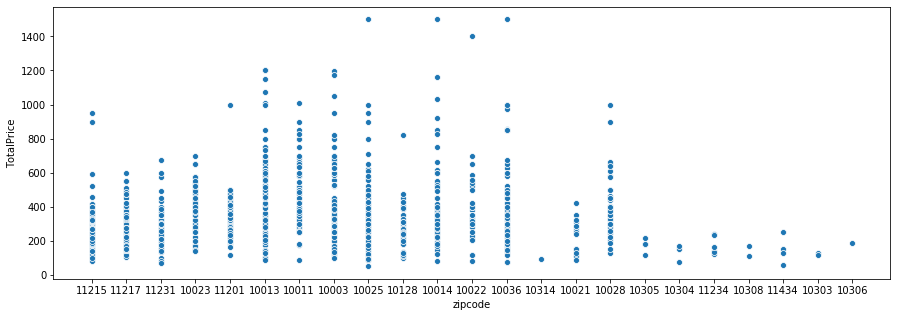

In [183]:
listings_2bed_zip_clean_price = listings_2bed_zip_clean[listings_2bed_zip_clean['TotalPrice']<=1500].copy()
sns.scatterplot(x=listings_2bed_zip_clean_price['zipcode'], y=listings_2bed_zip_clean_price['TotalPrice'])

Verifying how many price data points are there for each zipcode

In [184]:
CountPricePerZip = listings_2bed_zip_clean_price.groupby('zipcode')['TotalPrice'].count().sort_values(ascending = False)
CountPricePerZip

zipcode
11215    152
11217    106
10003     98
10025     84
10036     77
10013     70
10014     70
11231     69
10011     68
11201     64
10028     54
10023     50
10128     47
10022     34
10021     16
11234      6
10305      5
11434      4
10304      3
10308      2
10303      2
10306      1
10314      1
Name: TotalPrice, dtype: int64

In [188]:
median_listings = round(listings_2bed_zip_clean_price.groupby('zipcode')['TotalPrice'].median(), 2)
median_listings

zipcode
10003    329.5
10011    387.0
10013    475.0
10014    355.0
10021    244.5
10022    350.0
10023    377.5
10025    315.0
10028    375.0
10036    350.0
10128    270.0
10303    122.5
10304    150.0
10305    182.0
10306    185.0
10308    139.5
10314     93.0
11201    297.5
11215    240.0
11217    275.0
11231    275.0
11234    152.0
11434    140.0
Name: TotalPrice, dtype: float64

Considering that the occupation is 75%, lets calculate the revenue per year

In [190]:
RentalRevenueZipYear = round(median_listings*365*0.75, 2)
RentalRevenueZipYear

zipcode
10003     90200.62
10011    105941.25
10013    130031.25
10014     97181.25
10021     66931.88
10022     95812.50
10023    103340.62
10025     86231.25
10028    102656.25
10036     95812.50
10128     73912.50
10303     33534.38
10304     41062.50
10305     49822.50
10306     50643.75
10308     38188.12
10314     25458.75
11201     81440.62
11215     65700.00
11217     75281.25
11231     75281.25
11234     41610.00
11434     38325.00
Name: TotalPrice, dtype: float64

Creating a Dataframe with RentalRevenueZipYear and CountPricePerZip

In [192]:
RevenueAndCount = pd.DataFrame(RentalRevenueZipYear).merge(pd.DataFrame(CountPricePerZip), on = 'zipcode', how='left')
RevenueAndCount.rename(columns={'TotalPrice_x':'RentalRevenueZipYear', 'TotalPrice_y':'CountPricePerZip'}, inplace=True)
RevenueAndCount

,RentalRevenueZipYear,CountPricePerZip
zipcode,,
10003,90200.62,98
10011,105941.25,68
10013,130031.25,70
10014,97181.25,70
10021,66931.88,16
10022,95812.50,34
10023,103340.62,50
10025,86231.25,84
10028,102656.25,54


In [196]:
PriceZipPrediction = PriceZipPrediction.merge(RevenueAndCount, left_on='ZipCode', right_on='zipcode', how='left')

In [197]:
PriceZipPrediction

,ZipCode,City,State,CountyName,Borough,Date,PricePrediction,RentalRevenueZipYear,CountPricePerZip
0,10314,New York,NY,Richmond,Staten Island,2019-07-01,370222.64,25458.75,1.0
1,10306,New York,NY,Richmond,Staten Island,2019-07-01,373215.33,50643.75,1.0
2,10312,New York,NY,Richmond,Staten Island,2019-07-01,380404.16,NaN,NaN
3,10304,New York,NY,Richmond,Staten Island,2019-07-01,323444.65,41062.50,3.0
4,10305,New York,NY,Richmond,Staten Island,2019-07-01,414771.21,49822.50,5.0
5,10309,New York,NY,Richmond,Staten Island,2019-07-01,408498.10,NaN,NaN
6,10308,New York,NY,Richmond,Staten Island,2019-07-01,411297.32,38188.12,2.0
7,10303,New York,NY,Richmond,Staten Island,2019-07-01,324659.55,33534.38,2.0
8,10036,New York,NY,New York,Manhattan,2019-07-01,1960173.09,95812.50,77.0
9,11434,New York,NY,Queens,Queens,2019-07-01,306552.70,38325.00,4.0


Finally we will calculate and add the the brake-even time in years per zipcode so we will know which zipcode has the properties that would provide the fastest profits

In [198]:
PriceZipPrediction['YearsToProfit'] = round(PriceZipPrediction['PricePrediction']/PriceZipPrediction['RentalRevenueZipYear'],2)

Printing the dataframe ordering by YearsToProfit ascending, so  the data will be organized from least time to profit to longest time to profit. Remembering that zipcodes 10312 and 10309 are not part of the analysis because the Airbnb with 2 bedrooms did not have said zipcodes

In [199]:
PriceZipPrediction[PriceZipPrediction['YearsToProfit']>0].sort_values(by='YearsToProfit', ascending=True)

,ZipCode,City,State,CountyName,Borough,Date,PricePrediction,RentalRevenueZipYear,CountPricePerZip,YearsToProfit
1,10306,New York,NY,Richmond,Staten Island,2019-07-01,373215.33,50643.75,1.0,7.37
3,10304,New York,NY,Richmond,Staten Island,2019-07-01,323444.65,41062.50,3.0,7.88
9,11434,New York,NY,Queens,Queens,2019-07-01,306552.70,38325.00,4.0,8.00
4,10305,New York,NY,Richmond,Staten Island,2019-07-01,414771.21,49822.50,5.0,8.32
7,10303,New York,NY,Richmond,Staten Island,2019-07-01,324659.55,33534.38,2.0,9.68
10,11234,New York,NY,Kings,Brooklyn,2019-07-01,436171.74,41610.00,6.0,10.48
6,10308,New York,NY,Richmond,Staten Island,2019-07-01,411297.32,38188.12,2.0,10.77
0,10314,New York,NY,Richmond,Staten Island,2019-07-01,370222.64,25458.75,1.0,14.54
11,11231,New York,NY,Kings,Brooklyn,2019-07-01,1173344.16,75281.25,69.0,15.59
13,11215,New York,NY,Kings,Brooklyn,2019-07-01,1033642.62,65700.00,152.0,15.73


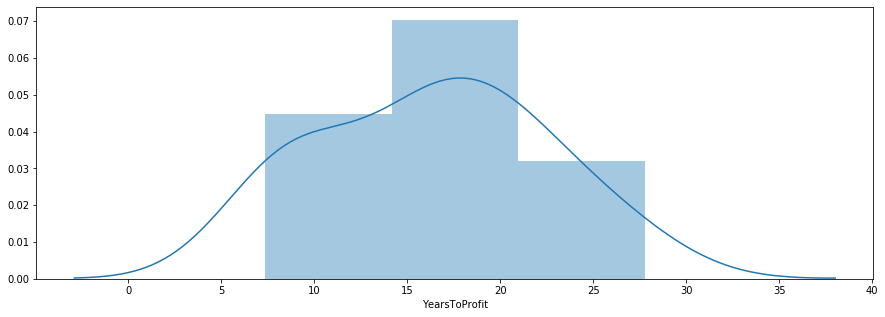

In [208]:
dist = PriceZipPrediction[PriceZipPrediction['YearsToProfit']>0]
sns.distplot(dist['YearsToProfit'])

Key Business Insights

The crosstab chart above clearly shows us that zipcodes 10306, 10304, 11434, 10305, 10303, 11234, and 10308 are the ones that recoup the entire money spent on the property the earliest. However for zip codes 11434, 10303, 10304, 10306, 10308 there are only 4 or less price data points, so I recommend the investment to be made in the zip codes 11234 and 10305 considering they will achieve break-even in less than 10.5 years. I would also consider zip code 11231, even though it would take a little more than 15 years to achieve break-even, it has 69 data price points, which increases the confidence the average price is close to reality.

Although the majority of zip codes with the quickest recoup are on Staten Island, almost all of them have few data price points, on the other hand zip codes on Manhattan have several data price points, but the time required for break-even ranges from 15 to 27 years. Brooklyn has the zip codes with the biggest number of data price points and Queens has only one zip code represented in the list.

Approximately 52.5% of the property by zip code groups will achieve break-even in the range of 14 to 21 years, 30.1% in the range of 7 to 13 years, and 17.4% in the range of 22 to 28 years

In [209]:
#exporting data to .csv for Tableau Dashboard development
PriceZipPrediction.to_csv(r'C:\Users\Anderson\Documents\C1 Challenge\PriceZipPrediction.csv')